# VA Pricing example
This script generates an inforce file, prices it and then builds a few predictive models to approximate model results without having to do full blow calculations. The main steps involve:
1. Inforce and product description generation
2. Scenario generation
    1. Pull historical market data
    2. Estimate market parameters from historical data
3. Projection calculation
4. Approximation of projection
    1. Build NN using cell characteristics as input to predict the projection out put to avoid having to run the projection

## Import libraries
1. Pandas is needed for dataframe manipulation
2. Numpy is needed for array handling
3. Yfinance is used to pull market data
4. Tensorflow is used to build projection approximator
5. seaborn and matplotlib are used for plotting
6. sklearn is used for scenario generation model

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import mixture
import os

## Inforce Generation
General context: <br>
A GMDB (Guaranteed Minimum Death Benefit) pays out the difference between the death benefit and the account value on the death of the policyholder. Different types change how the death benefit is calculated as the contract ages. <br>
A GLWB (Guaranteed Lifetime Withdrawal Benefit) guarantees a certain level of income for life usually a % of premiums paid in with a potential increase from market growth.<br>
Both of the above leave the insurer open to market risk since the guarantess must be paid even if the account value is insufficient to cover the cost. It is typical to assess the value of the guarantess frequently to understand the market risk associated with them and this script provides a flavor of that valuation exercise along with a way to approximate the slow Monte Carlo simulation.

This section generates the inforce file containing contract details to be used later on. Each contract has:
1. Issue Age: How old the policyholder was when they bought the contract, uniformly distributed between 50 and 70
2. Duration:  How long the contract has been inforce in years, uniformly distributed between 0 and 10
3. Premiums: Amount initially paid in: log normally distributed with mu = 11.5 and sigma = 0.5
3. Gender: 50/50 chance of male/female
5. Account Value: Premimums * (1 + Random normal with mean of 0 and sd of 0.3)
6. Withdrawal indicator: Whether the contract is taking withdrawals.
    - Chance of No is 0.8^(min(Duration,1))* (0.95)^(max(Duration-1,0))
    - This represents a 20% chance of beginning taking withdrawals during the first year and a 5% chance each year thereafter
7. Withdrawal benefit type: Ratchet (RA) or Return of Premium (ROP) with 50/50 chance of each. 
    - A ratchet's benefit base will be adjusted each year to be the greater of the current account value and current benefit base. 
    - An ROP is simply Premiums
8. Death Benefit Type: Same as above except applying to the death benefit instead
9. Benefit Base: max(Account Value, Premiums) if a ratchet. Premiums otherwise
10. Death Benefit: Same as above
11. Base Contract fee: 0.0075 applied to account value annually
12. Withdrawal Benefit Fee: 0.0025 for ROP and 0.005 for ratchets. Applied to benefit base annually
13. Death Benefit Fee: 0.00125 for ROP and 0.0025 for ratchets. Applied to account value annually
14. Equity %s: The amount the contract has invested in each of three broad equity indices. Generated with three lognormal random variables with sigma of 1 and various mus. Results are normalized so that sum of equity %'s is one
    - SPX_PCT: % of AV invested in S&P500. mu = 2
    - NDX_PCT: % of AV invested in Nasdaq. mu = 1
    - RTK_PCT: % of AV invested in Russell. mu = 0

In [2]:
num_contracts = 10000
rng = np.random.default_rng(seed = 42)
inforce_data = pd.DataFrame(
{
    "ISSUE_AGE" : rng.uniform(50, 70, num_contracts),
    "DURATION" : rng.uniform(0, 10, num_contracts),
    "PREM" : np.exp(rng.normal(11.5, 0.5, num_contracts)),
    "GENDER" :  np.where(rng.uniform(0,1,num_contracts)<0.5,"M","F")
})
inforce_data["AV"] = inforce_data.PREM*(1+rng.normal(0, 0.3, num_contracts))
inforce_data["WD_IND"] = np.where(rng.uniform(0,1,num_contracts)<
                               0.8**np.minimum(inforce_data.DURATION,1)*0.95**np.maximum(inforce_data.DURATION -1,0),"N","Y")
inforce_data["WB_TYPE"] = np.where(rng.uniform(0,1,num_contracts)<0.5,"RA","ROP")
inforce_data["DB_TYPE"] = np.where(rng.uniform(0,1,num_contracts)<0.5,"RA","ROP")
inforce_data["WB_BASE"] = np.where(inforce_data.WB_TYPE=="RA",np.maximum(inforce_data.PREM, inforce_data.AV),inforce_data.PREM)
inforce_data["DB_BASE"] = np.where(inforce_data.DB_TYPE=="RA",np.maximum(inforce_data.PREM, inforce_data.AV),inforce_data.PREM)
inforce_data["BASE_FEE"] = 0.0075
inforce_data["WB_FEE"] = np.where(inforce_data.WB_TYPE=="RA",0.005,0.0025)
inforce_data["DB_FEE"] = np.where(inforce_data.DB_TYPE=="RA",0.0025,0.00125)
equity_pcts = np.exp(rng.multivariate_normal(mean = np.array([2,1,0]),
                                     cov = np.array([[1,0,0],
                                                    [0,1,0],
                                                    [0,0,1]]),
                                     size = num_contracts))
equity_pcts = (equity_pcts.transpose()/np.sum(equity_pcts,axis = 1)).transpose() # transpose to allow for easy arithmetic
inforce_data[['SPX_PCT','NDX_PCT','RTK_PCT']] = equity_pcts

In [3]:
# Check that distribution of values looks correct
inforce_data['DURATION_BANDS'] = pd.cut(inforce_data.DURATION, bins = np.arange(0,11,1))
print(inforce_data.head())
print("Amount withdrawing decreases to about 50% as Duration increases as expected")
print(inforce_data.groupby(['DURATION_BANDS','WD_IND']).
                   size())
print("Distribution of both WB and DB type is 50/50 as expected")
print(inforce_data.groupby(['WB_TYPE']).size())
print(inforce_data.groupby(['DB_TYPE']).size())

   ISSUE_AGE  DURATION           PREM GENDER             AV WD_IND WB_TYPE  \
0  65.479121  7.207284   39620.974221      F   53162.952520      N      RA   
1  58.777569  7.112378   81036.569584      F   96648.944927      N     ROP   
2  67.171958  2.026950   41183.770337      M   39004.552419      N     ROP   
3  63.947361  0.366554  273968.767640      F  265660.637963      N      RA   
4  51.883547  3.037995  109781.313675      F   25450.508845      Y     ROP   

  DB_TYPE        WB_BASE        DB_BASE  BASE_FEE  WB_FEE   DB_FEE   SPX_PCT  \
0      RA   53162.952520   53162.952520    0.0075  0.0050  0.00250  0.580469   
1     ROP   81036.569584   81036.569584    0.0075  0.0025  0.00125  0.792989   
2      RA   41183.770337   41183.770337    0.0075  0.0025  0.00250  0.580849   
3      RA  273968.767640  273968.767640    0.0075  0.0050  0.00250  0.856954   
4      RA  109781.313675  109781.313675    0.0075  0.0025  0.00250  0.245684   

    NDX_PCT   RTK_PCT DURATION_BANDS  
0  0.344602

## Scenario Generation
An important question when pricing these guarantees is what the distribution of future market returns will be. The less volatile the market the less valuable the guarantee will be to the policyholder so assessing market volatility is crucial. To do that we will pull historical data and see what distribution makes the most sense
### Pull historical market data
Pull monthly SPX, NDX, and RTK prices and calculates total monthly returns for use in determining parameters for scenario generation

In [4]:
ticker_names = ["^GSPC","^NDX","^RUT"]
all_tickers = yf.download(" ".join(ticker_names), start="1990-01-01", end="2021-08-01", interval = "1mo",
                         group_by="ticker")
all_returns = []
for ticker in ticker_names:
    all_returns.append(np.log(all_tickers[ticker]["Close"]/all_tickers[ticker]["Open"]))
all_returns = np.stack(all_returns).transpose()
all_tickers

[*********************100%***********************]  3 of 3 completed


^RUT                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
1990-01-01   168.309998   170.800003   152.440002   153.270004   153.270004   
1990-02-01   153.270004   160.350006   153.270004   157.720001   157.720001   
1990-03-01   157.710007   164.839996   157.389999   163.630005   163.630005   
1990-04-01   163.630005   163.669998   157.410004   158.089996   158.089996   
1990-05-01   158.089996   169.110001   158.089996   168.910004   168.910004   
...                 ...          ...          ...          ...          ...   
2021-04-01  2225.290039  2322.909912  2171.679932  2266.449951  2266.449951   
2021-05-01  2268.620117  2288.570068  2132.250000  2268.969971  2268.969971   
2021-06-01  2270.379883  2350.699951  2229.580078  2310.550049  2310.550049   
2021-07-01  2312.570068  2332.949951  2107.070068  2226.250000  2226.250000   
2021-08-01  2228.030029  2286.360107  2122.239990  2273.770020  2273.770020   

                               ^GSPC                                         \
                 Volume         Open         High          Low        Close   
Date                                                                          
1990-01-01   3793250000   353.399994   360.589996   319.829987   329.079987   
1990-02-01   2961970000   329.079987   336.089996   322.100006   331.890015   
1990-03-01   3283280000   331.890015   344.489990   331.079987   339.940002   
1990-04-01   2801220000   339.940002   347.299988   327.760010   330.799988   
1990-05-01   3596680000   330.799988   362.260010   330.799988   361.230011   
...                 ...          ...          ...          ...          ...   
2021-04-01  79003470000  3992.780029  4218.779785  3992.780029  4181.169922   
2021-05-01  75155370000  4191.979980  4238.040039  4056.879883  4204.109863   
2021-06-01  85705180000  4216.520020  4302.430176  4164.399902  4297.500000   
2021-07-01  66496430000  4300.729980  4429.970215  4233.129883  4395.259766   
2021-08-01  63217960000  4406.859863  4537.359863  4367.729980  4522.680176   

                                              ^NDX                \
              Adj Close       Volume          Open          High   
Date                                                               
1990-01-01   329.079987   3793250000    223.835007    228.940002   
1990-02-01   331.890015   2961970000    201.940002    210.434998   
1990-03-01   339.940002   3283280000    207.914993    220.134995   
1990-04-01   330.799988   2801220000    213.145004    218.250000   
1990-05-01   361.230011   3596680000    205.815002    237.925003   
...                 ...          ...           ...           ...   
2021-04-01  4181.169922  82869290000  13268.879883  14073.480469   
2021-05-01  4204.109863  75155370000  13923.040039  13955.000000   
2021-06-01  4297.500000  85705180000  13764.269531  14582.299805   
2021-07-01  4395.259766  66496430000  14530.629883  15142.349609   
2021-08-01  4522.680176  63217960000  15046.099609  15620.620117   

                                                                    
                     Low         Close     Adj Close        Volume  
Date                                                                
1990-01-01    196.684998    201.940002    201.940002    6059660000  
1990-02-01    200.404999    207.914993    207.914993    4841840000  
1990-03-01    206.524994    213.145004    213.145004    5774900000  
1990-04-01    202.970001    205.815002    205.815002    5182900000  
1990-05-01    205.815002    236.149994    236.149994    6937140000  
...                  ...           ...           ...           ...  
2021-04-01  13255.820312  13860.759766  13860.759766   91050570000  
2021-05-01  12967.179688  13686.509766  13686.509766   88957750000  
2021-06-01  13469.849609  14554.799805  14554.799805  107636930000  
2021-07-01  14455.070312

### Appropriateness of normal assumption
While it is typical to use a normal assumption for equity returns (more out of convenience than anything else) it can be unrealistic as shown in the charts below, where the normal assumption peaks at a different spot than the acutal returns and doesn't have as heavy negative tails 

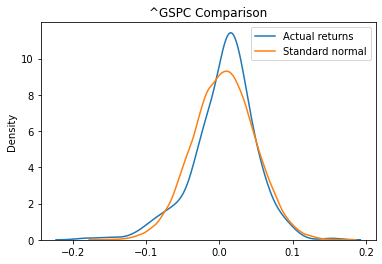

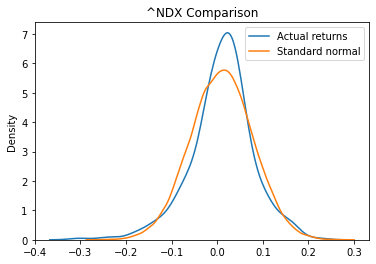

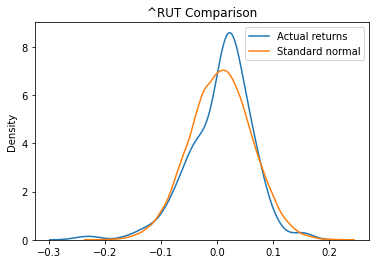

In [5]:
def plot_returns_vs_normal(ticker_index):
    # ticker_index should be between 0 and the number of tickers pulled - 1
    rng = np.random.default_rng(seed = 20)
    random_normal_returns = rng.normal(np.mean(all_returns[:,ticker_index]), 
                                          np.std(all_returns[:,ticker_index]),100000)
    ax = sns.kdeplot(all_returns[:,ticker_index], label = "Actual returns")
    ax = sns.kdeplot(random_normal_returns, label = "Standard normal")
    plt.title(ticker_names[ticker_index] + " Comparison")
    plt.legend()
    plt.show()
for ticker_index in range(0, len(ticker_names)):
    plot_returns_vs_normal(ticker_index)

A more suitable alternative to the normal assumption is a Gaussian Mixture Model
A Gaussian Mixture model assumes that the data comes from multiple normal distributions as opposed to just one. Not being limited to just one bell curve gives the model the needed flexibility to fit different assumptions

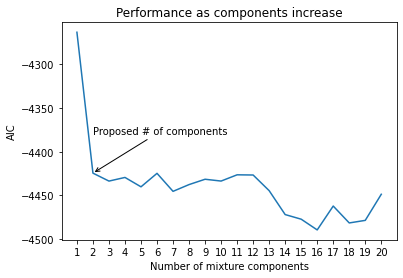

In [6]:
def generate_mixture_model(num_components, ticker_index, return_model = True):
    # num components is the number of components to generate for the mixture model
    # ticker_index should be between 0 and number of tickers pulled - 1
    # return_model is a flag for whether the full model and its inputs should be returned. If this is false just the performance will be returned
        # for quick comparison between different models
    mixture_model = mixture.GaussianMixture(n_components = num_components, covariance_type = 'full',random_state=20)
    mixture_model.fit(all_returns)
    if return_model:
        return [mixture_model, all_returns]
    else:
        return mixture_model.aic(all_returns)
all_mixture_results = np.zeros(shape = (20))
all_components = []
for num_components in range(0, all_mixture_results.shape[0]):
    all_mixture_results[num_components] = generate_mixture_model(num_components+1, ticker_index, False)
    all_components.append(num_components + 1)
fig = plt.plot(all_components,all_mixture_results)
plt.xticks(all_components, labels = all_components)
plt.annotate("Proposed # of components",xy = (2,all_mixture_results[1]),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3",color='black'),
             xycoords = "data",
            xytext = (2,all_mixture_results[1]*0.99))
plt.xlabel("Number of mixture components")
plt.ylabel("AIC")
plt.title('Performance as components increase')
plt.show()

While we could theoretically have a slightly better fit with a 20 or so component model, most of the improvement in performance comes just from adding one component. Also, having fewer components makes it easier to understand and defend what is going on in our scenario generation process so 2 components seems good for now 

In [7]:
num_components = 2
full_mixture_model = generate_mixture_model(num_components, ticker_index, True)
full_mixture_model[0].means_
full_mixture_model[0].covariances_
full_mixture_model[0].correlations_ = full_mixture_model[0].covariances_.copy()
for mixture_num in range(0,num_components):
    for row in range(0,len(ticker_names)):
        for column in range(0,len(ticker_names)):
            full_mixture_model[0].correlations_[mixture_num,row,column] = np.round(full_mixture_model[0].covariances_[mixture_num,row,column]/(np.sqrt(full_mixture_model[0].covariances_[mixture_num,row,row])*np.sqrt(full_mixture_model[0].covariances_[mixture_num,column,column])),4)
print("Indices are highly correlated in both regimes as is intuitive.")
print(full_mixture_model[0].correlations_)
print("Indices are in a state or rising (row 1) or crashing (row 2). Again this fits intuition and reality more than the more benign normal assumption")
print(np.round(full_mixture_model[0].means_,4))

Indices are highly correlated in both regimes as is intuitive.
[[[1.     0.8033 0.8312]
  [0.8033 1.     0.742 ]
  [0.8312 0.742  1.    ]]

 [[1.     0.8574 0.8065]
  [0.8574 1.     0.7669]
  [0.8065 0.7669 1.    ]]]
Indices are in a state or rising (row 1) or crashing (row 2). Again this fits intuition and reality more than the more benign normal assumption
[[-0.0102 -0.0108 -0.0151]
 [ 0.0124  0.0174  0.0145]]


Adding another component largely fixes the disconnect between the theroetical and observed distribution of returns, further emphasizing that 2 components is sufficient for our purpose

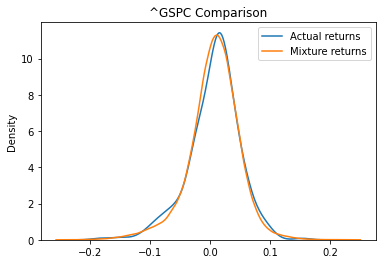

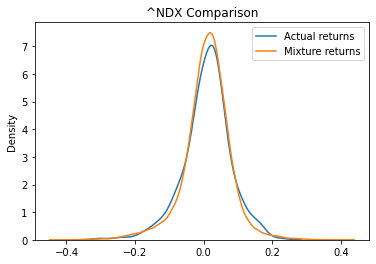

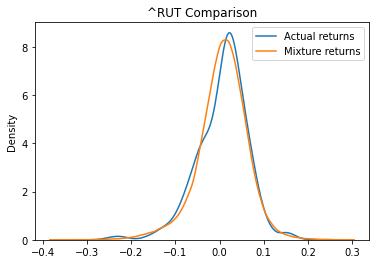

In [8]:
def plot_returns_vs_mixture(ticker_index):
    # ticker_index should be between 0 and the number of tickers pulled - 1
    random_mixture_returns = full_mixture_model[0].sample(100000)[0]
    ax = sns.kdeplot(all_returns[:,ticker_index], label = "Actual returns")
    ax = sns.kdeplot(random_mixture_returns[:,ticker_index], label = "Mixture returns")
    plt.title(ticker_names[ticker_index] + " Comparison")
    plt.legend()
    plt.show()
for ticker_index in range(0, len(ticker_names)):
    plot_returns_vs_mixture(ticker_index)

The mixture model provides predictions of which regime we are in so we can use those predictions to estimate the chance of moving from the high return to the low return regime

In [9]:
def create_transition_matrix(states):
    # states should be integers beginning at 0 and increasing by one
    unique_states = np.unique(states)
    return_matrix = np.zeros(shape = (len(unique_states),len(unique_states)))
    for row in unique_states:
        for col in unique_states:
            return_matrix[row,col] = np.sum(np.logical_and(states[1:]==col,states[:-1]==row))/np.sum(states[:-1]==row)
    return return_matrix
state_transitions = create_transition_matrix(full_mixture_model[0].predict(all_returns))

With the model parameterised we can now generate the scenario file

In [10]:
num_scenarios = 1000
num_periods = 480
rng = np.random.default_rng(seed = 100)
scenario_returns = np.zeros(shape = (num_scenarios, num_periods, 4))# item 4 is a discount factor
current_state = np.repeat(full_mixture_model[0].predict(all_returns)[-1:],num_scenarios)
for period in range(0, num_periods):
    rand_unifs = rng.uniform(0,1,num_scenarios)
    current_state = np.where(current_state==0,
                        np.where(rand_unifs < state_transitions[0,0],0,1),
                        np.where(rand_unifs < state_transitions[1,1],1,0))
    scenario_returns[:,period,0:3] = np.where((current_state.reshape(num_scenarios,1)==0),
                                            rng.multivariate_normal(mean= full_mixture_model[0].means_[0], 
                                                                    cov = full_mixture_model[0].covariances_[0,:,:],
                                                                  size =num_scenarios),
                                            rng.multivariate_normal(mean= full_mixture_model[0].means_[1], 
                                                                    cov = full_mixture_model[0].covariances_[1,:,:],
                                                                    size =num_scenarios))
    scenario_returns[:,period,3] = np.exp(-0.015*((period+1)/12)) # simple 1.5% discounting

## Inforce projection
Inforce projection has the following order of operations:
1. Adjust AV, death benefit and withdrawal benefit based on market movements
2. Policyholder takes withdrawals and triggers any potential wb claims once AV hits 0
3. Fees deducted from AV
4. DB Claims paid out based on chance of death in/survival to that year 

### Mortality
Pull mortality table for use in determining probability of death
This file comes from https://mort.soa.org/ViewTable.aspx?&TableIdentity=2582
and https://mort.soa.org/ViewTable.aspx?&TableIdentity=2581

In [11]:
mortality_table = pd.read_csv(os.getcwd()+'\\Supporting_Data\\Mortality_table.csv')
mortality_table = mortality_table.to_numpy()[:,1:] # converto numpy for easier lookups
mortality_table

array([[1.78300e-03, 1.80100e-03],
       [4.46000e-04, 4.50000e-04],
       [3.06000e-04, 2.87000e-04],
       [2.54000e-04, 1.99000e-04],
       [1.93000e-04, 1.52000e-04],
       [1.86000e-04, 1.39000e-04],
       [1.84000e-04, 1.30000e-04],
       [1.77000e-04, 1.22000e-04],
       [1.59000e-04, 1.05000e-04],
       [1.43000e-04, 9.80000e-05],
       [1.26000e-04, 9.40000e-05],
       [1.23000e-04, 9.60000e-05],
       [1.47000e-04, 1.05000e-04],
       [1.88000e-04, 1.20000e-04],
       [2.36000e-04, 1.46000e-04],
       [2.82000e-04, 1.74000e-04],
       [3.25000e-04, 1.99000e-04],
       [3.64000e-04, 2.20000e-04],
       [3.99000e-04, 2.34000e-04],
       [4.30000e-04, 2.45000e-04],
       [4.59000e-04, 2.53000e-04],
       [4.92000e-04, 2.60000e-04],
       [5.26000e-04, 2.66000e-04],
       [5.69000e-04, 2.72000e-04],
       [6.16000e-04, 2.75000e-04],
       [6.69000e-04, 2.77000e-04],
       [7.28000e-04, 2.84000e-04],
       [7.64000e-04, 2.90000e-04],
       [7.89000e-04,

In [20]:
%%time
def project_inforce(inforce_file, scenario_file, mortality_assumption, rng_seed = 30):
    # set seed for reproducibility
    rng = np.random.default_rng(rng_seed)
    # store scenario period and contract numbers since they are used a log
    num_scenarios = scenario_file.shape[0]
    num_periods = scenario_file.shape[1]
    num_contracts = inforce_file.shape[0]
    #print(num_contracts)
    # store miscellaneous demographic information
    ages = np.array(inforce_file.ISSUE_AGE+inforce_file.DURATION)
    durations = np.array(inforce_file.DURATION)
    gender_column = np.where(inforce_file.GENDER=="M",0,1)
    fund_mix = inforce_file[['SPX_PCT','NDX_PCT','RTK_PCT']].to_numpy().reshape((num_contracts,1,3))# fund mix assumed to be constant  
    av_fee = (inforce_file.BASE_FEE+inforce_file.DB_FEE).to_numpy()
    wb_fee = inforce_file.WB_FEE.to_numpy()
    # copy a bunch of arrays to store values for later use
    av = np.zeros(shape = (num_scenarios,num_periods+1, num_contracts)) # +1 on number of periods to allow for time-0 information
    db = av.copy()
    wb = av.copy()
    mort_chance = av.copy()
    survival_chance = av.copy()
    wd_ind = inforce_file.WD_IND.to_numpy()
    wds = av.copy()
    wb_claims = av.copy()
    db_claims = av.copy()
    fees = av.copy()
    av[:,0,:] = inforce_file.AV
    db[:,0,:] = inforce_file.DB_BASE
    wb[:,0,:] = inforce_file.WB_BASE
    survival_chance[:,0,:] = 1
    for period in range(0, num_periods):
        mort_chance[:,period+1,:] = 1-(1-mortality_table[np.minimum(np.rint(ages).astype(int),120), # round to lookup based on age
                                                    gender_column])**(1./12) # converts from annual to monthly
        survival_chance[:,period + 1,:] = survival_chance[:,period,:]*(1-mort_chance[:,period+1,:]) # walk forward survival chance as the chance of having survived up until previous month times the chance of not dying that month
        policy_anniversary = (np.ceil(durations)!=np.ceil(durations+1/12))# check if policy anniversary happens since that is when fees are applied
        av[:,period+1,:] = av[:,period,:]*np.exp(np.sum(fund_mix*scenario_file[:,period,0:3],axis = 2).transpose())# fund performance is weighted sum of index returns and percent the policyholder has in those indices
        wb[:,period+1,:] = np.where(np.logical_and(inforce_file.WB_TYPE.to_numpy()=="RA",policy_anniversary),
                                    np.maximum(wb[:,period,:],av[:,period,:]),wb[:,period,:]) # if it is a policyholder's anniversary and they own a Ratcher on the WB increase it if possible. otherwise just bring forward the old value
        
        db[:,period+1,:] = np.where(np.logical_and(inforce_file.DB_TYPE.to_numpy()=="RA",policy_anniversary),
                                    np.maximum(db[:,period,:],av[:,period,:]),db[:,period,:])# same as above except for db
        wd_ind = np.where(wd_ind=="Y","Y",# people taking withdrawals continue doing so
                         np.where(rng.uniform(0,1)<1-(1-0.05)**(1/12)*0,"Y","N"))# people not taking withdrawals have a 5% chance to start. Those already taknig withdrawals are assumed to continue forever
        wds[:,period+1,:] = np.where(wd_ind=="Y",0.07/12*wb[:,period+1,:],0)# the contract allows withdrawing 7% per year so withdraw each month
        # adjust death benefit down for withdrawals $4$
        db[:,period+1,:] = np.maximum(db[:,period+1,:]-wds[:,period+1,:],0)
        # record if the policy has triggered claims by drawing their AV down to 0. since this is an output field do add the chance of curvival to the calculation as well
        wb_claims[:,period+1,:] = survival_chance[:,period+1,:]*np.maximum(wds[:,period+1,:]-av[:,period+1,:],0)
        # adjust AV down as well and don't let AV be 0
        av[:,period+1,:] = np.maximum(av[:,period+1,:]-wds[:,period+1,:],0)
        # if it is the policy anniversary collect fees. Don't weight this by the chance of surviving to this point because we have to deduct this amount from AV still
        fees[:,period+1,:] = np.where(policy_anniversary,av[:,period+1,:]*av_fee+
                                                          np.minimum(wb[:,period+1,:]*wb_fee,av[:,period+1,:]*(1-av_fee)),# floor at AV*(1-AV_Fee) because AV_Fee is charged in conjuction with this step
                                                          0)
        # pay out DB claims if DB < AV. This is another output field so weight it by the cahnce of surviving to that point and then dying
        db_claims[:,period+1,:] = survival_chance[:,period,:]*mort_chance[:,period+1,:]*np.maximum(db[:,period+1,:]-av[:,period+1,:],0)
        av[:,period+1,:] = av[:,period+1,:]-fees[:,period+1,:]# deduct fees from AV. note that there is no floor of 0 since there are controls on the fee calc to prevent charging a fee greater than the account value
        fees[:,period+1,:] *= survival_chance[:,period+1,:] # adjust based on probability of surviving to that point
        ages = ages + 1/12
        durations = durations + 1/12
    # 4 slot in third dimension of scenario file is discount factor to bring projection back to a present value. We then want to average across the various
    # scenarios and then sum up over time
    by_cell_fees = np.sum(np.mean(fees[:,1:,]*scenario_file[:,:,3].reshape(num_scenarios,num_periods,1),axis=0),axis = 0)
    by_cell_db_claims = np.sum(np.mean(db_claims[:,1:,]*scenario_file[:,:,3].reshape(num_scenarios,num_periods,1),axis=0),axis = 0)
    by_cell_wb_claims = np.sum(np.mean(wb_claims[:,1:,]*scenario_file[:,:,3].reshape(num_scenarios,num_periods,1),axis=0),axis = 0)

    return pd.concat([inforce_file.reset_index(), # reset_index necessary for concat to work
                      pd.DataFrame({
        "Fees": by_cell_fees,
        "DB Claims": by_cell_db_claims,
        "WB Claims": by_cell_wb_claims
    })], axis =1)
inforce_with_model_results = project_inforce(inforce_data.iloc[np.arange(1*inforce_offset,(1+1)*50),:],
                                             scenario_returns, mortality_table)# test that function works correctly

CPU times: total: 3.33 s
Wall time: 3.35 s


## Populate model results for full inforce
Note this section takes about 10 minutes to run

In [13]:
%%time
all_model_results = []
inforce_offset = 50
for inforce_start in range(0,200,1):
    model_results= project_inforce(inforce_data.iloc[np.arange(inforce_start*inforce_offset,(inforce_start+1)*inforce_offset),:],
                                  scenario_returns,
                                  mortality_table)
    all_model_results.append(model_results)
    print(inforce_start*inforce_offset)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
CPU times: total: 10min

In [14]:
concat_model_results = pd.concat(all_model_results)
concat_model_results.shape # confirm that we have the same number of rows as output as we had as input

(10000, 21)

## Model approximation
One way to improve on the slow speed of the above is to use just a few contracts to learn an approximation of the model's output and then predict the rest of the contract's results based on that

### Input preparation
Add the following fields to the dataset to help it learn:
1. WB Moneyness: Ratio of AV to WB_Base
2. DB Moneyness: Ratio of AV to DB_Base
3. FEE_PCT_AV_WB: Ratio of Fees to AV + WB Base
4. MALE_FLAG: convert GENDER to 0/1 for female/male
5. WB_RA_FLAG: convert WB_TYPE to flag for ratchet on the WB
6. WD_FLAG: convert WB_IND to flag for whether taking withdrawals
7. DB_RA_FLAG: convert DB_TYPE to flag for ratcher on DB
8. DB_CLAIMS_PCT_DB: Ratio of DB claims to current DB Base
9. WB_CLAIMS_PCT_WB: Ratio of WB claims to current WB Base

Also create list of fields used as input for approximation

In [15]:
concat_model_results['WB_MONEYNESS'] = concat_model_results.AV/concat_model_results.WB_BASE
concat_model_results['DB_MONEYNESS'] = concat_model_results.AV/concat_model_results.DB_BASE
concat_model_results['MALE_FLAG'] = np.where(concat_model_results.GENDER=="M",1,0)
concat_model_results['WB_RA_FLAG'] = np.where(concat_model_results.WB_TYPE=="RA",1,0)
concat_model_results['WD_FLAG'] = np.where(concat_model_results.WD_IND=="Y",1,0)
concat_model_results['DB_RA_FLAG'] = np.where(concat_model_results.DB_TYPE=="RA",1,0)
concat_model_results['DB_CLAIMS_PCT_DB'] = concat_model_results['DB Claims']/concat_model_results.DB_BASE
concat_model_results['WB_CLAIMS_PCT_WB'] = concat_model_results['WB Claims']/concat_model_results.WB_BASE
concat_model_results['FEE_PCT_AV_WB'] = concat_model_results['Fees']/(concat_model_results.WB_BASE + concat_model_results.AV)

candidates =  ['ISSUE_AGE', 'DURATION', 'MALE_FLAG', 'WB_MONEYNESS','DB_MONEYNESS','WD_FLAG','WB_RA_FLAG','DB_RA_FLAG','SPX_PCT',
               'NDX_PCT','RTK_PCT']
outputs = ['DB_CLAIMS_PCT_DB', 'FEE_PCT_AV_WB','WB_CLAIMS_PCT_WB']

In [22]:
# build neural network and take a look at its structure
input_layer = tf.keras.Input(shape = len(candidates))
processing = tf.keras.layers.Dense(units = 40, activation = "relu")(input_layer)
output_layer = tf.keras.layers.Dense( units = 3, activation = "linear")(processing)
model = tf.keras.Model(input_layer,output_layer)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_4 (Dense)             (None, 40)                480       
                                                                 
 dense_5 (Dense)             (None, 3)                 123       
                                                                 
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# break data into training, validation and testing and fit model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), 
    optimizer="adam"
)
# important to reduce LR and stop early to prevent overfitting
model_callbacks = [tf.keras.callbacks.EarlyStopping(patience = 20),
                  tf.keras.callbacks.ReduceLROnPlateau(patience = 5)]
train_inp = concat_model_results[candidates][0:1800]
val_inp = concat_model_results[candidates][1801:2000]
test_inp = concat_model_results[candidates][2001:]
train_out = concat_model_results[outputs][0:1800]
val_out = concat_model_results[outputs][1801:2000]
test_out = concat_model_results[outputs][2001:]
model.fit(train_inp, train_out,epochs = 500,
         validation_data = (val_inp,val_out),callbacks=model_callbacks
             )

Epoch 1/500
57/57 [==============================] - 1s 6ms/step - loss: 22.9387 - val_loss: 0.5458 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 0s 5ms/step - loss: 0.2938 - val_loss: 0.2491 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 0s 3ms/step - loss: 0.2146 - val_loss: 0.2026 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 0s 2ms/step - loss: 0.1705 - val_loss: 0.1612 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 0s 3ms/step - loss: 0.1364 - val_loss: 0.1320 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 0s 2ms/step - loss: 0.1114 - val_loss: 0.1121 - lr: 0.0010
Epoch 7/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0921 - val_loss: 0.0933 - lr: 0.0010
Epoch 8/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0769 - val_loss: 0.0821 - lr: 0.0010
Epoch 9/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0661 - val_loss: 0.0710 - lr

57/57 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0230 - lr: 1.0000e-04
Epoch 74/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0229 - lr: 1.0000e-04
Epoch 75/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0230 - lr: 1.0000e-04
Epoch 76/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0230 - lr: 1.0000e-04
Epoch 77/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0229 - lr: 1.0000e-04
Epoch 78/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0229 - lr: 1.0000e-04
Epoch 79/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0228 - lr: 1.0000e-04
Epoch 80/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0229 - lr: 1.0000e-05
Epoch 81/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0

In [24]:
# test approximation
model.evaluate(test_inp,test_out)
test_predictions = model.predict(test_inp)
test_predictions[:,0]*=concat_model_results[2001:].DB_BASE
test_predictions[:,1]*=(concat_model_results[2001:].AV + concat_model_results[2001:].WB_BASE)
test_predictions[:,2]*=concat_model_results[2001:].WB_BASE

250/250 [==============================] - 0s 1ms/step


In [25]:
np.sum(test_predictions,axis =0)/concat_model_results[2001:][['DB Claims','Fees', 'WB Claims']].agg(sum).to_numpy()
# given that this is a noisy Monte Carlo estimate, being mostly within 5% of the groud truth is not bad! and it took a lot less time than the full blow run did for the last 8000 contracts 

array([0.99099079, 1.03223303, 0.96600166])